# Fast-RCNN
------
We didn't upload the score of this part because the RCNN related model usually needs pretraining to obtain good accuracy. However, the dataset for pretraining is too large for our computer and network speed, but we are curious how the pretrained model can perform so we decided to complete this model but with downloaded pretrain model which is illegal. In the following section, we'll use *PyTorch* instead of Tensorflow to implement the process.

![Alt text](https://i.imgur.com/0gAX9ku.png "Optional title")

# Preprocessing
------
The dataset given is preprocessed with **selective search data**, but the post-processing code wasn't really useful, so we re-write it by ourself.

In [1]:
import sys
import pickle
import tqdm
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from PIL import Image
from tqdm import trange
from utils import *
from roi import *

First we load the given selective search data :

In [2]:
train_pkl_path = 'data/train_data.pkl'
data = pickle.load(open(train_pkl_path, 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'data/train_data.pkl'

Then we collect the features stored in the given pickle to according arrays, and resize every images to **224x224**, so every picture become small and having same size, which is simple and efficient for training.

In [ ]:
train_imgs = []
train_img_info = []
train_roi = []
train_cls = []
train_tbbox = []

N_train = len(data)
for i in trange(N_train):
    img_path = data['image_name'][i]
    gt_boxs = data['boxes'][i]
    gt_classes = data['gt_classes'][i]
    nobj = data['num_objs'][i]
    bboxs = data['selective_search_boxes'][i]
    nroi = len(bboxs)

    img = Image.open('data/JPEGImages/' + img_path)
    img_size = img.size
    img = img.resize((224, 224))
    img = np.array(img).astype(np.float32)
    img = np.transpose(img, [2, 0, 1])

    rbboxs = rel_bbox(img_size, bboxs)
    ious = calc_ious(bboxs, gt_boxs)
    max_ious = ious.max(axis=1)
    max_idx = ious.argmax(axis=1)
    tbbox = bbox_transform(bboxs, gt_boxs[max_idx])

    pos_idx = []
    neg_idx = []

    for j in range(nroi):
        if max_ious[j] < 0.1:
            continue

        gid = len(train_roi)
        train_roi.append(rbboxs[j])
        train_tbbox.append(tbbox[j])

        if max_ious[j] >= 0.5:
            pos_idx.append(gid)
            train_cls.append(gt_classes[max_idx[j]])
        else:
            neg_idx.append(gid)
            train_cls.append(0)

    pos_idx = np.array(pos_idx)
    neg_idx = np.array(neg_idx)
    train_imgs.append(img)
    train_img_info.append({
        'img_size': img_size,
        'pos_idx': pos_idx,
        'neg_idx': neg_idx,
    })
    #print(len(pos_idx), len(neg_idx))

Converting them to `np.array()`, and then save the transformed data into a new *.npz* file.

In [ ]:
train_imgs = np.array(train_imgs)
train_img_info = np.array(train_img_info)
train_roi = np.array(train_roi)
train_cls = np.array(train_cls)
train_tbbox = np.array(train_tbbox).astype(np.float32)

print(f'Training image dataset shape : {train_imgs.shape}')
print(f'ROI : {train_roi.shape}, Train_cls : {train_cls.shape}, Train_tbbox : {train_tbbox.shape}')

np.savez(open('data/train.npz', 'wb'), 
         train_imgs=train_imgs, train_img_info=train_img_info,
         train_roi=train_roi, train_cls=train_cls, train_tbbox=train_tbbox)

The preprocessing of the testing data is quite the same.

In [ ]:
test_pkl_path = 'data/test_data.pkl'
data = pickle.load(open(test_pkl_path, 'rb'))

In [ ]:
test_imgs = []
test_img_info = []
test_roi = []
test_orig_roi = []

In [ ]:
N_test = len(data)
for i in trange(N_test):
    img_path = data['image_name'][i]
    bboxs = data['selective_search_boxes'][i]
    nroi = len(bboxs)

    img = Image.open('data/JPEGImages/' + img_path)
    img_size = img.size
    img = img.resize((224, 224))
    img = np.array(img).astype(np.float32)
    img = np.transpose(img, [2, 0, 1])

    rbboxs = rel_bbox(img_size, bboxs)
    idxs = []

    for j in range(nroi):
        gid = len(test_roi)
        test_roi.append(rbboxs[j])
        test_orig_roi.append(bboxs[j])
        idxs.append(gid)

    idxs = np.array(idxs)
    test_imgs.append(img)
    test_img_info.append({
        'img_size': img_size,
        'idxs': idxs
    })

In [ ]:
test_imgs = np.array(test_imgs)
test_img_info = np.array(test_img_info)
test_roi = np.array(test_roi)
test_orig_roi = np.array(test_orig_roi)

print(f'Testing image dataset shape : {test_imgs.shape}')

np.savez(open('data/test.npz', 'wb'), 
         test_imgs=test_imgs, test_img_info=test_img_info, test_roi=test_roi, test_orig_roi=test_orig_roi)

# Utilities
------
Before training, we construct some utility functions for convenience, most of them are from the given lecture/hint codes:

In [2]:
def rel_bbox(size, bbox):
    bbox = bbox.astype(np.float32)
    bbox[:,0] /= size[0]
    bbox[:,1] /= size[1]
    bbox[:,2] += 1
    bbox[:,2] /= size[0]
    bbox[:,3] += 1
    bbox[:,3] /= size[1]
    return bbox

In [3]:
def bbox_transform(ex_rois, gt_rois):
    ex_widths = ex_rois[:,2] - ex_rois[:,0] + 1.0
    ex_heights = ex_rois[:,3] - ex_rois[:,1] + 1.0
    ex_ctr_x = ex_rois[:,0] + 0.5 * ex_widths
    ex_ctr_y = ex_rois[:,1] + 0.5 * ex_heights

    gt_widths = gt_rois[:,2] - gt_rois[:,0] + 1.0
    gt_heights = gt_rois[:,3] - gt_rois[:,1] + 1.0
    gt_ctr_x = gt_rois[:,0] + 0.5 * gt_widths
    gt_ctr_y = gt_rois[:,1] + 0.5 * gt_heights

    targets_dx = (gt_ctr_x - ex_ctr_x) / ex_widths
    targets_dy = (gt_ctr_y - ex_ctr_y) / ex_heights
    targets_dw = np.log(gt_widths / ex_widths)
    targets_dh = np.log(gt_heights / ex_heights)

    targets = np.array([targets_dx, targets_dy, targets_dw, targets_dh]).T
    return targets

In [4]:
def calc_ious(ex_rois, gt_rois):
    ex_area = (1. + ex_rois[:,2] - ex_rois[:,0]) * (1. + ex_rois[:,3] - ex_rois[:,1])
    gt_area = (1. + gt_rois[:,2] - gt_rois[:,0]) * (1. + gt_rois[:,3] - gt_rois[:,1])
    area_sum = ex_area.reshape((-1, 1)) + gt_area.reshape((1, -1))

    lb = np.maximum(ex_rois[:,0].reshape((-1, 1)), gt_rois[:,0].reshape((1, -1)))
    rb = np.minimum(ex_rois[:,2].reshape((-1, 1)), gt_rois[:,2].reshape((1, -1)))
    tb = np.maximum(ex_rois[:,1].reshape((-1, 1)), gt_rois[:,1].reshape((1, -1)))
    ub = np.minimum(ex_rois[:,3].reshape((-1, 1)), gt_rois[:,3].reshape((1, -1)))

    width = np.maximum(1. + rb - lb, 0.)
    height = np.maximum(1. + ub - tb, 0.)
    area_i = width * height
    area_u = area_sum - area_i
    ious = area_i / area_u
    return ious

In [5]:
def reg_to_bbox(img_size, reg, box):
    img_width, img_height = img_size
    bbox_width = box[:,2] - box[:,0] + 1.0
    bbox_height = box[:,3] - box[:,1] + 1.0
    bbox_ctr_x = box[:,0] + 0.5 * bbox_width
    bbox_ctr_y = box[:,1] + 0.5 * bbox_height

    bbox_width = bbox_width[:,np.newaxis]
    bbox_height = bbox_height[:,np.newaxis]
    bbox_ctr_x = bbox_ctr_x[:,np.newaxis]
    bbox_ctr_y = bbox_ctr_y[:,np.newaxis]

    out_ctr_x = reg[:,:,0] * bbox_width + bbox_ctr_x
    out_ctr_y = reg[:,:,1] * bbox_height + bbox_ctr_y

    out_width = bbox_width * np.exp(reg[:,:,2])
    out_height = bbox_height * np.exp(reg[:,:,3])

    return np.array([
        np.maximum(0, out_ctr_x - 0.5 * out_width),
        np.maximum(0, out_ctr_y - 0.5 * out_height),
        np.minimum(img_width, out_ctr_x + 0.5 * out_width),
        np.minimum(img_height, out_ctr_y + 0.5 * out_height)
    ]).transpose([1, 2, 0])

The following non_maximum_suppression() filters the boxes that are overlapped.

In [6]:
def non_maximum_suppression(sc, bboxs, iou_threshold=0.7, score_threshold=0.6):
    nroi = sc.shape[0]
    idx = np.argsort(sc)[::-1]
    rb = 0
    while rb < nroi and sc[idx[rb]] >= score_threshold:
        rb += 1
    if rb == 0:
        return []
    idx = idx[:rb]
    sc = sc[idx]
    bboxs = bboxs[idx,:]
    ious = calc_ious(bboxs, bboxs)

    res = []
    for i in range(rb):
        if i == 0 or ious[i, :i].max() < iou_threshold:
            res.append(bboxs[i])

    return res

In [7]:
def plot (name, title, legendx, legendy, x, y, n_epoch, frame_size = 256,labelx = 'Epoch', labely = 'Loss'):
    i = 0
    x = np.array(x).flatten('F')
    y = np.array(y).flatten('F')
    framex = []
    framey = []
    
    while i*frame_size < len(x):
        framex.append(np.mean(x[i*frame_size:min(len(x),(i+1)*frame_size)]))
        framey.append(np.mean(y[i*frame_size:min(len(y),(i+1)*frame_size)]))
        i += 1
    
    a = np.arange(0,len(x),len(x)/len(framex))
    b = a/len(y)*n_epoch
    a = a/len(x)*n_epoch
    
    plt.figure()
    plt.plot(a,framex)
    plt.plot(b,framey)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.title(title)
    plt.legend([legendx,legendy])
    plt.savefig(name,dpi=600)
    plt.show()

# Model : Fast-RCNN
------
Our model is constructed based on the Fast-RCNN model, which is introduced by Ross Girshick in 2015. Generally speaking, RCNN is implemented through four following steps :

1. Obtain about 1000~2000 selective search boxes in each data (which is done in the given dataset)
2. Apply Convolutional newral network to each selective search boxes, and obtain features
3. Apply Classifier to the features obtained in the CNN model to classify if it belongs to any category.
4. Apply Regression to refine the search boxes into more accurate position

But the problem is that RCNN performs at a super slow speed, how slow it is? Considering the given TA's code, the CNN model is fed by the complete (resized) image, and 1 epoch takes about 75 seconds with GTX1080Ti, how about feeding the model with selective search boxes which is a 1000 to 2000 times larger dataset? Then 1 epoch will take about 20 hours, which is too slow for our hardware and deadline.

So we come to Fast-RCNN, and the model flowchart is shown above :
![Alt text](http://img.blog.csdn.net/20160411214438672 "Optional title")

-----
As we can see, the model is a type of CNN, with RELU and Max_pooling. For the fifth pooling, the layer is changed with **ROI pooling**, which divide every selective search boxes into *MxN* sections evenly, and apply max-pooling for each sections. Finally, ROI pooling transfer the vary sized selective search data into a uniformed data, and send them to the next layer.
The code is shown below:

In [8]:
class SlowROIPool(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.maxpool = nn.AdaptiveMaxPool2d(output_size)
        self.size = output_size

    def forward(self, images, rois, roi_idx):
        n = rois.shape[0]
        h = images.size(2)
        w = images.size(3)
        x1 = rois[:,0]
        y1 = rois[:,1]
        x2 = rois[:,2]
        y2 = rois[:,3]

        x1 = np.floor(x1 * w).astype(int)
        x2 = np.ceil(x2 * w).astype(int)
        y1 = np.floor(y1 * h).astype(int)
        y2 = np.ceil(y2 * h).astype(int)
        
        res = []
        for i in range(n):
            img = images[roi_idx[i]].unsqueeze(0)
            img = img[:, :, y1[i]:y2[i], x1[i]:x2[i]]
            img = self.maxpool(img)
            res.append(img)
        res = torch.cat(res, dim=0)
        return res

In order to implement the model with better performance, we use the VGG16 model, which is the same as the structure used in Fast-RCNN paper, and we switch the last pooling layer into our modified ROI-pooling layer.

![Alt text](https://junzhangcom.files.wordpress.com/2017/08/vgg16.png "Optional title")

In [9]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()

        rawnet = torchvision.models.vgg16_bn(pretrained=True)
        self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])
        self.roipool = SlowROIPool(output_size=(7, 7))
        self.feature = nn.Sequential(*list(rawnet.classifier.children())[:-1])

        _x = Variable(torch.Tensor(1, 3, 224, 224))
        _r = np.array([[0., 0., 1., 1.]])
        _ri = np.array([0])
        _x = self.feature(self.roipool(self.seq(_x), _r, _ri).view(1, -1))
        feature_dim = _x.size(1)
        self.cls_score = nn.Linear(feature_dim, N_CLASS+1)
        self.bbox = nn.Linear(feature_dim, 4*(N_CLASS+1))
        
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.SmoothL1Loss()

    def forward(self, inp, rois, ridx):
        res = inp
        res = self.seq(res)
        res = self.roipool(res, rois, ridx)
        res = res.detach()
        res = res.view(res.size(0), -1)
        feat = self.feature(res)

        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat).view(-1, N_CLASS+1, 4)
        return cls_score, bbox

    def calc_loss(self, probs, bbox, labels, gt_bbox):
        loss_sc = self.cel(probs, labels)
        lbl = labels.view(-1, 1, 1).expand(labels.size(0), 1, 4)
        mask = (labels != 0).float().view(-1, 1).expand(labels.size(0), 4)
        loss_loc = self.sl1(bbox.gather(1, lbl).squeeze(1) * mask, gt_bbox * mask)
        lmb = 1.0
        loss = loss_sc + lmb * loss_loc
        return loss, loss_sc, loss_loc

To accelerate the processing progress, we compute in *cuda()* instead of computing in CPU, and we can see the structure in the following block:

In [10]:
N_CLASS = 20

Transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

rcnn = RCNN().cuda()
print(rcnn)

RCNN (
  (seq): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU (inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU (inplace)
    (13): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (16): ReLU (inplace)
    (17): Conv2d(

-----
We load the preprocessed data, disorganize and split them into train and test data with ratio 4:1. The optimizer used in the training process is Adam stochastic optimization.

In [11]:
npz = np.load('data/train.npz')
train_imgs = npz['train_imgs']
train_img_info = npz['train_img_info']
train_roi = npz['train_roi']
train_cls = npz['train_cls']
train_tbbox = npz['train_tbbox']

train_imgs = torch.from_numpy(train_imgs)
train_imgs = Transform(train_imgs)

Ntotal = train_imgs.size(0)
Ntrain = int(Ntotal * 0.8)
pm = np.random.permutation(Ntotal)
train_set = pm[:Ntrain]
val_set = pm[Ntrain:]

optimizer = torch.optim.Adam(rcnn.parameters(), lr=1e-4)

The following functions defines the training batches generation, epoch training/validation.

In [12]:
def train_batch(img, rois, ridx, gt_cls, gt_tbbox, is_val=False):
    sc, r_bbox = rcnn(img, rois, ridx)
    loss, loss_sc, loss_loc = rcnn.calc_loss(sc, r_bbox, gt_cls, gt_tbbox)
    fl = loss.data.cpu().numpy()[0]
    fl_sc = loss_sc.data.cpu().numpy()[0]
    fl_loc = loss_loc.data.cpu().numpy()[0]

    if not is_val:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return fl, fl_sc, fl_loc

def train_epoch(run_set, is_val=False):
    I = 2
    B = 64
    POS = int(B * 0.25)
    NEG = B - POS
    Nimg = len(run_set)
    perm = np.random.permutation(Nimg)
    perm = run_set[perm]
    losses = []
    losses_sc = []
    losses_loc = []
    
    for i in trange(0, Nimg, I):
        lb = i
        rb = min(i+I, Nimg)
        torch_seg = torch.from_numpy(perm[lb:rb])
        img = Variable(train_imgs[torch_seg], volatile=is_val).cuda()
        ridx = []
        glo_ids = []

        for j in range(lb, rb):
            info = train_img_info[perm[j]]
            pos_idx = info['pos_idx']
            neg_idx = info['neg_idx']
            ids = []

            if len(pos_idx) > 0:
                ids.append(np.random.choice(pos_idx, size=POS))
            if len(neg_idx) > 0:
                ids.append(np.random.choice(neg_idx, size=NEG))
            if len(ids) == 0:
                continue
            ids = np.concatenate(ids, axis=0)
            glo_ids.append(ids)
            ridx += [j-lb] * ids.shape[0]

        if len(ridx) == 0:
            continue
        glo_ids = np.concatenate(glo_ids, axis=0)
        ridx = np.array(ridx)

        rois = train_roi[glo_ids]
        gt_cls = Variable(torch.from_numpy(train_cls[glo_ids]), volatile=is_val).cuda()
        gt_tbbox = Variable(torch.from_numpy(train_tbbox[glo_ids]), volatile=is_val).cuda()

        loss, loss_sc, loss_loc = train_batch(img, rois, ridx, gt_cls, gt_tbbox, is_val=is_val)
        losses.append(loss)
        losses_sc.append(loss_sc)
        losses_loc.append(loss_loc)

    avg_loss = np.mean(losses)
    avg_loss_sc = np.mean(losses_sc)
    avg_loss_loc = np.mean(losses_loc)
    print(f'Avg loss = {avg_loss:.4f}; loss_sc = {avg_loss_sc:.4f}, loss_loc = {avg_loss_loc:.4f}')
    
    return losses, losses_sc, losses_loc

Then we define the process with 1 training epoch with 1 validation epoch. Besides training, we store the loss during the training process and plot them with our plotting function.

In [13]:
def start_training(n_epoch=2):
    tl = []
    ts = []
    to = []
    vl = []
    vs = [] 
    vo = []
    for i in range(n_epoch):
        print(f'===========================================')
        print(f'[Training Epoch {i+1}]')
        train_loss, train_sc, train_loc = train_epoch(train_set, False)
        print(f'[Validation Epoch {i+1}]')
        val_loss, val_sc, val_loc = train_epoch(val_set, True)
        
        tl.append(train_loss)
        ts.append(train_sc)
        to.append(train_loc)
        vl.append(val_loss)
        vs.append(val_sc)
        vo.append(val_loc)
        
    plot('loss','Train/Val : Loss', 'Train', 'Validation', tl, vl, n_epoch)
    plot('loss_sc','Train/Val : Loss_sc', 'Train', 'Validation', ts, vs, n_epoch)
    plot('loss_loc','Train/Val : Loss_loc', 'Train', 'Validation', to, vo, n_epoch)

Testing process is nearly the same as training, while the boxes is calculated mainly from `non_maximum_suppression()`, which is introduced in the utilities.

In [14]:
npz = np.load('data/test.npz')
test_imgs = npz['test_imgs']
test_img_info = npz['test_img_info']
test_roi = npz['test_roi']
test_orig_roi = npz['test_orig_roi']

test_imgs = torch.from_numpy(test_imgs)
test_imgs = Transform(test_imgs).cuda()

In [15]:
def test_image(img, img_size, rois, orig_rois):
    nroi = rois.shape[0]
    ridx = np.zeros(nroi).astype(int)
    sc, tbbox = rcnn(img, rois, ridx)
    sc = nn.functional.softmax(sc)
    sc = sc.data.cpu().numpy()
    tbbox = tbbox.data.cpu().numpy()
    bboxs = reg_to_bbox(img_size, tbbox, orig_rois)

    res_bbox = []
    res_cls = []

    for c in range(1, N_CLASS+1):
        c_sc = sc[:,c]
        c_bboxs = bboxs[:,c,:]

        boxes = non_maximum_suppression(c_sc, c_bboxs, iou_threshold=0.3, score_threshold=0.6)
        res_bbox.extend(boxes)
        res_cls.extend([c] * len(boxes))

    if len(res_cls) == 0:
        for c in range(1, N_CLASS+1):
            c_sc = sc[:,c]
            c_bboxs = bboxs[:,c,:]

            boxes = non_maximum_suppression(c_sc, c_bboxs, iou_threshold=0.3, score_threshold=0.3)
            res_bbox.extend(boxes)
            res_cls.extend([c] * len(boxes))
        res_bbox = res_bbox[:1]
        res_cls = res_cls[:1]

    print(res_cls)

    return np.array(res_bbox), np.array(res_cls)

Finally, we define the testing process and send the final generated data into the given `evaluate()` function to obtain the final *output.csv* file.

In [16]:
def test_epoch():
    Nimg = test_imgs.size(0)
    Nc = Nimg

    perm = np.random.permutation(Nimg)[:Nc]

    bbox_preds = []
    bbox_cls = []

    for i in range(Nimg):
        bbox_preds.append(np.ndarray((0, 4)))
        bbox_cls.append(np.ndarray((0, 1)))

    for i in range(Nc):
        pi = perm[i]
        img = Variable(test_imgs[pi:pi+1], volatile=True)
        ridx = []
        glo_ids = []

        info = test_img_info[pi]
        img_size = info['img_size']
        idxs = info['idxs']

        idxs = np.array(idxs)
        rois = test_roi[idxs]
        orig_rois = test_orig_roi[idxs]

        res_bbox, res_cls = test_image(img, img_size, rois, orig_rois)
        bbox_preds[pi] = res_bbox
        bbox_cls[pi] = res_cls

    evaluate.evaluate(bbox_preds, bbox_cls)

    print('Test complete')

1. For initial training, comment the following loading line, uncomment the training/saving lines.
2. For continual training, uncomment all of the following line.
3. For pure testing, uncomment the loading line, comment the training/saving lines.

Observing the loss graph, we can see that due to pretraining, the loss is already low in the initial training epoch, and is about to well-fit in the third epoch.


  0%|          | 0/4159 [00:00<?, ?it/s]

[Training Epoch 1]


  0%|          | 3/1040 [00:00<00:42, 24.62it/s]

Avg loss = 0.7839; loss_sc = 0.7696, loss_loc = 0.0143
[Validation Epoch 1]


  0%|          | 2/4159 [00:00<03:30, 19.79it/s]

Avg loss = 0.6817; loss_sc = 0.6728, loss_loc = 0.0089
[Training Epoch 2]


  0%|          | 3/1040 [00:00<00:39, 26.44it/s]

Avg loss = 0.6183; loss_sc = 0.6101, loss_loc = 0.0082
[Validation Epoch 2]


  0%|          | 3/4159 [00:00<03:32, 19.53it/s]

Avg loss = 0.6560; loss_sc = 0.6485, loss_loc = 0.0074
[Training Epoch 3]


  0%|          | 3/1040 [00:00<00:38, 26.85it/s]

Avg loss = 0.5486; loss_sc = 0.5411, loss_loc = 0.0075
[Validation Epoch 3]


100%|██████████| 1040/1040 [00:26<00:00, 38.52it/s]
/home/gary/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/gary/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Avg loss = 0.6561; loss_sc = 0.6492, loss_loc = 0.0069


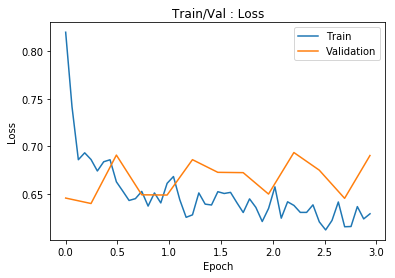

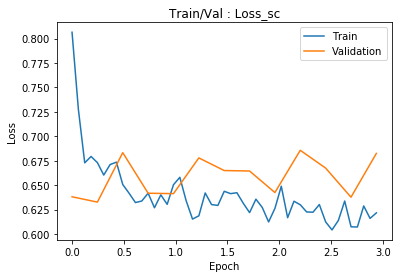

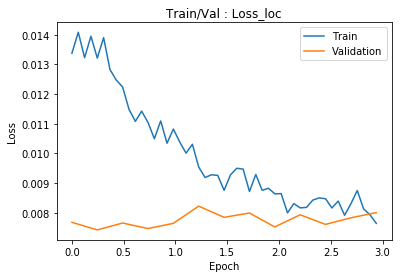

In [17]:
#rcnn.load_state_dict(torch.load('model/hao123.mdl'))
start_training(n_epoch=3)
torch.save(rcnn.state_dict(), 'model/hao123.mdl')

In [ ]:
test_epoch()